<a href="https://colab.research.google.com/github/ffelicioni/tp_infoviz/blob/main/Nodos_social_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nodos - SocialNetworks

## Modulos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import ScalarMappable

import networkx as nx
from networkx.readwrite import json_graph

import community.community_louvain as community_louvain
from networkx.algorithms import community 

import itertools

import community.community_louvain as community_louvain

from networkx.readwrite import json_graph
import json

## Funciones

In [2]:
def preparar_matriz_adyacencia(df):
    n=np.max(df.participantIdTo)+1
    mat_ady = np.zeros([n, n], dtype = int)
    df2=df.copy()
    df2['index_from'] = df2[['participantIdFrom','participantIdTo']].min(axis=1)
    df2['index_to'] = df2[['participantIdFrom','participantIdTo']].max(axis=1)
    df2=df2[['index_from','index_to','month']].groupby(['index_from','index_to']).count()
    for i in range(0,len(df2.month.values)):
        valores=df2.month.values[i]
        indices=np.array([df2.month.index[i][0],df2.month.index[i][1]])
        mat_ady[indices[0]][indices[1]]=valores
    
    mat_ady=.5*(mat_ady+mat_ady.T)
    return mat_ady



def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def desc_degree_centrality(graph):
    centrality = nx.degree_centrality(graph)
    return sorted(centrality.items(), key=lambda x: x[1], reverse=True)

def top_degree_centrality_subgraph(graph, top=30):
    nodes = top_degree_centrality(graph, top)
    return graph.subgraph(dict(nodes))

def top_degree_centrality(graph, limit=10):
    return desc_degree_centrality(graph)[1:limit]

def subgraph_without_isolated_nodes(graph):
    return graph.subgraph(set(graph.nodes) - isolated_nodes(graph))

def isolated_nodes(graph): return set(nx.isolates(graph))

def subgraph_without_isolated_nodes(graph):
    return graph.subgraph(set(graph.nodes) - isolated_nodes(graph))

def assign_community_girvan_newman(G):
  modulos = nx.community.girvan_newman(G)
  modularidad=[]
  mod_max = -999

  for communities in modulos:
      #print(tuple(sorted(c) for c in communities))
      n_modularidad = nx.community.modularity(G,tuple(sorted(c) for c in communities))
      #print(n_modularidad)
      modularidad.append(n_modularidad)
      if n_modularidad>mod_max:
        mod_max=n_modularidad
        com_max = tuple(sorted(c) for c in communities)
  print(modularidad)
  plt.plot(modularidad);
  plt.xlabel('Diferentes particiones')
  plt.ylabel('Coeficiente de Modularidad')
  k=np.argmax(modularidad)
  print(mod_max)
  print(com_max)
  return k, mod_max, com_max, communities

def partition_set_to_dict(m):
    d = {}
    for i,c in enumerate(m):
        for n in c:
            d[n] = i
    return d

## Datasets

In [3]:
path='https://raw.githubusercontent.com/ffelicioni/tp_infoviz/main/data'
participants=pd.read_csv(path+"/Attributes/Participants.csv")

In [4]:
grupos={'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8, 'I':9,'J':10}
participants['group']=participants.interestGroup.map(grupos)
participants

,participantId,householdSize,haveKids,age,educationLevel,interestGroup,joviality,group
0,0,3,True,36,HighSchoolOrCollege,H,0.001627,8
1,1,3,True,25,HighSchoolOrCollege,B,0.328087,2
2,2,3,True,35,HighSchoolOrCollege,A,0.393470,1
3,3,3,True,21,HighSchoolOrCollege,I,0.138063,9
4,4,3,True,43,Bachelors,H,0.857397,8
...,...,...,...,...,...,...,...,...
1006,1006,1,False,19,HighSchoolOrCollege,J,0.639268,10
1007,1007,1,False,40,HighSchoolOrCollege,B,0.934348,2
1008,1008,1,False,23,Graduate,C,0.163721,3
1009,1009,1,False,39,Low,B,0.828330,2


In [5]:
participants['age_bin'] = pd.cut(participants['age'], [0, 25,30,35,40, 45, 50,55,65], labels=['A', 'B', 'C','D','E','F','G','H'])

participants['age_bin'] = pd.cut(participants['age'], [0, 20,30, 40,50,60], labels=['A', 'B', 'C','D','E'])

In [6]:
participants.age_bin.value_counts()

D    245
C    232
E    232
B    230
A     72
Name: age_bin, dtype: int64

Descomprimo dataset de SocialNetwork

In [7]:
!wget https://raw.githubusercontent.com/ffelicioni/tp_infoviz/main/data/Journals/SocialNetwork.zip
!unzip /content/SocialNetwork.zip

--2022-06-24 02:48:32--  https://raw.githubusercontent.com/ffelicioni/tp_infoviz/main/data/Journals/SocialNetwork.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25575878 (24M) [application/zip]
Saving to: ‘SocialNetwork.zip.2’

SocialNetwork.zip.2 100%[===================>]  24.39M  --.-KB/s    in 0.1s    

2022-06-24 02:48:34 (190 MB/s) - ‘SocialNetwork.zip.2’ saved [25575878/25575878]

Archive:  /content/SocialNetwork.zip
replace SocialNetwork.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: SocialNetwork.csv       


In [8]:
social_network=pd.read_csv("./SocialNetwork.csv",parse_dates=['timestamp'])#,index_col='timestamp')
social_network.dtypes

timestamp            datetime64[ns, UTC]
participantIdFrom                  int64
participantIdTo                    int64
dtype: object

In [9]:
social_network

,timestamp,participantIdFrom,participantIdTo
0,2022-03-01 00:00:00+00:00,173,180
1,2022-03-01 00:00:00+00:00,178,183
2,2022-03-01 00:00:00+00:00,178,185
3,2022-03-01 00:00:00+00:00,180,173
4,2022-03-01 00:00:00+00:00,183,178
...,...,...,...
7482483,2023-05-25 00:00:00+00:00,879,102
7482484,2023-05-25 00:00:00+00:00,879,851
7482485,2023-05-25 00:00:00+00:00,879,412
7482486,2023-05-25 00:00:00+00:00,879,17


### The day of the week with Monday=0, Sunday=6.

In [10]:
# agrego datos respecto del día
social_network['week']=social_network.timestamp.dt.isocalendar().week
social_network['day_of_week']=social_network.timestamp.dt.dayofweek
social_network['days_in_month']=social_network.timestamp.dt.days_in_month
social_network['month']=social_network.timestamp.dt.month
social_network['year']=social_network.timestamp.dt.year
social_network

,timestamp,participantIdFrom,participantIdTo,week,day_of_week,days_in_month,month,year
0,2022-03-01 00:00:00+00:00,173,180,9,1,31,3,2022
1,2022-03-01 00:00:00+00:00,178,183,9,1,31,3,2022
2,2022-03-01 00:00:00+00:00,178,185,9,1,31,3,2022
3,2022-03-01 00:00:00+00:00,180,173,9,1,31,3,2022
4,2022-03-01 00:00:00+00:00,183,178,9,1,31,3,2022
...,...,...,...,...,...,...,...,...
7482483,2023-05-25 00:00:00+00:00,879,102,21,3,31,5,2023
7482484,2023-05-25 00:00:00+00:00,879,851,21,3,31,5,2023
7482485,2023-05-25 00:00:00+00:00,879,412,21,3,31,5,2023
7482486,2023-05-25 00:00:00+00:00,879,17,21,3,31,5,2023


## Si se quiere seleccionar por algún mes/año o condición

In [11]:
fecha_ini='2022-05-01 00:00:00+00:00'
df=social_network[(social_network.timestamp>=fecha_ini)]
# (social_network.month==4) & (social_network.year==2022)
df

social_network=[]

In [12]:
print('cantidad de personas que envian mensajes: ',len(df.participantIdFrom.unique()))
print('cantidad de personas que reciben mensajes: ', len(df.participantIdTo.unique()))

cantidad de personas que envian mensajes:  880
cantidad de personas que reciben mensajes:  880


Armo matriz de adyacencia de las comunicaciones. Considero la cantidad de mensajes que hubo entre los participantes (son los pesos)

In [13]:
mat_ady=preparar_matriz_adyacencia(df)
print(mat_ady)

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. 16. ...  0.  0.  0.]
 [ 0. 16.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0. 70.]
 [ 0.  0.  0. ...  0. 70.  0.]]


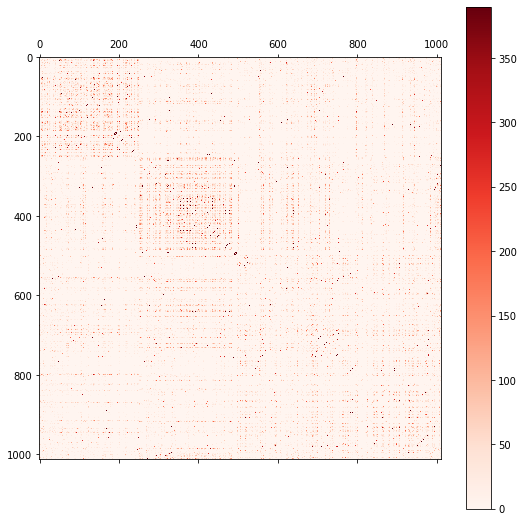

In [14]:
plt.figure(figsize=(9, 9))
plt.matshow(mat_ady, fignum=1,cmap='Reds')
plt.colorbar()
#plt.suptitle('Matriz Adyacencia')

## Nodos

In [15]:
G = nx.from_numpy_matrix(mat_ady)

print(nx.info(G))
print('Is weigthed:',nx.is_weighted(G))

G.number_of_nodes(), G.number_of_edges()

Graph with 1011 nodes and 77742 edges
Is weigthed: True


(1011, 77742)

In [16]:
#print('density:',nx.density(G))
#print('grado de asortatividad:',nx.degree_assortativity_coefficient(G))
#plt.hist(nx.clustering(G).values(),bins=np.arange(0.2,1,0.05))

In [17]:
#print('cantidad de elementos de la matriz:',len(mat_ady.flatten()))
#sns.histplot(mat_ady.flatten())

print(len(list(G.nodes)))

#print(list(G.edges))
#list(G.adj[1])

1011


se quedan 880

In [18]:
min_comm=10
g_list=[]
for (u, v, wt) in G.edges.data('weight'):
    if wt > min_comm:
        g_list.append([u,v,wt])
        #print(f"({u}, {v}, {wt})")

df2=pd.DataFrame(g_list).rename(columns={0:'participantId',1:'to',2:'weight'})
G1 = nx.from_pandas_edgelist(df2, 'participantId', 'to','weight', create_using=nx.Graph())

In [19]:
grupos = community_louvain.best_partition(G1,weight='weight')
nx.set_node_attributes(G1, grupos, "group")

In [20]:
print(nx.info(G1))
print('Is weigthed:',nx.is_weighted(G1))
print(nx.is_directed(G1))
G1.number_of_nodes(), G1.number_of_edges()

Graph with 880 nodes and 72295 edges
Is weigthed: True
False


(880, 72295)

Guardo los que tuvieron más de 100 comunicaciones



In [21]:
min_comm=100
g_list=[]
for (u, v, wt) in G1.edges.data('weight'):
    if wt > min_comm:
       g_list.append([u,v,wt])

df2=pd.DataFrame(g_list).rename(columns={0:'participantId',1:'to',2:'weight'})
G2 = nx.from_pandas_edgelist(df2, 'participantId', 'to','weight', create_using=nx.Graph())

subgrupo_top=top_degree_centrality_subgraph(G2, top = 600) #601

f = subgraph_without_isolated_nodes(subgrupo_top)

In [22]:
print(nx.info(f))
print('Is weigthed:',nx.is_weighted(f))

Graph with 599 nodes and 6147 edges
Is weigthed: True


In [23]:
print(nx.info(f))
print('Is weigthed:',nx.is_weighted(f))
print(nx.is_directed(f))
f.number_of_nodes(), f.number_of_edges()

Graph with 599 nodes and 6147 edges
Is weigthed: True
False


(599, 6147)

In [24]:
df0 = pd.DataFrame(f.degree,columns=['Node','group']).set_index('Node')
df0.T
df0.sort_values('group',ascending=False).T

Node,508,503,266,472,984,393,274,1009,258,424,...,969,483,891,73,820,733,961,988,960,515
group,64,60,55,55,53,53,51,50,50,50,...,6,6,6,6,6,6,5,5,5,5


Gráfico en el cual el color y el tamaño de los nodos depende de la centralidad de intermediación (betweenness)
La medida de intermediación mide la habilidad de un nodo de monitorear las comunicaciones entre otros nodos.

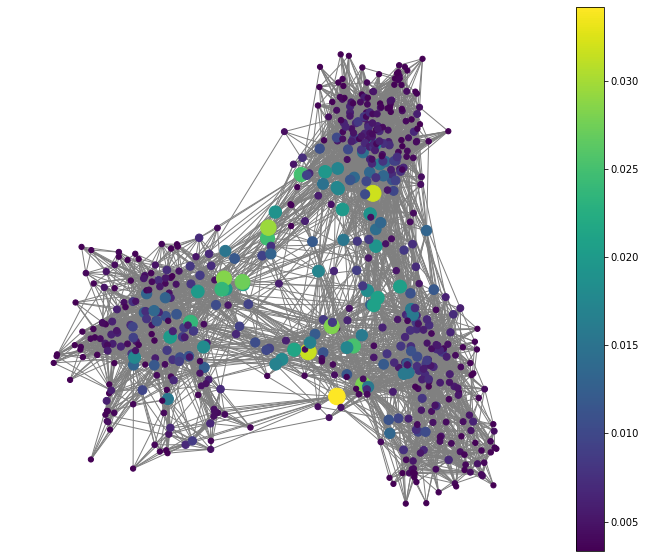

In [25]:
pos=nx.spring_layout(f,seed=0) #,weight='weight'
partition=nx.betweenness_centrality(f,normalized=True,endpoints=True)
deg_centrality = nx.degree_centrality(f)
eig_centrality = nx.eigenvector_centrality(f)
#values = [v for n,v in centrality.items()]

node_color = [v for v in partition.values()]
#node_color = [v for n,v in centrality.items()] #si quiero asignar color por centralidad
node_size = [v*8000 for v in partition.values()] 

# para louvain 
#grupos = community_louvain.best_partition(f)
#node_color = [v for n,v in partition.items()]

plt.figure(figsize=(12,10))
nx.draw_networkx(f, pos= pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size,
                 edge_color='gray') #font_color='white'
plt.axis('off')

sm=plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color))); sm.set_array([]); cbar = plt.colorbar(sm)

In [26]:
h=G1.subgraph(f)
nx.set_node_attributes(f, nx.get_node_attributes(h,'group'), "group")
#nx.set_node_attributes(h,)
nx.set_node_attributes(f,partition,"betweenness")
nx.set_node_attributes(f,deg_centrality,"degree")
nx.set_node_attributes(f,eig_centrality,"eigenvector")

In [27]:
json_f=json_graph.node_link_data(f)

with open('graph_social.json', 'w') as outfile1:
    outfile1.write(json.dumps(json_f))

In [28]:
nx.get_node_attributes(h,'group').values()

dict_values([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 10, 3, 3, 10, 10, 10, 10, 3, 10, 10, 10, 2, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 3, 10, 10, 10, 10, 10, 10, 2, 10, 10, 10, 2, 2, 3, 2, 2, 3, 3, 3, 2, 10, 2, 10, 10, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3, 3, 10, 3, 3, 3, 2, 2, 10, 3, 2, 3, 3, 3, 2, 3, 10, 3, 3, 3, 3, 3, 3, 10, 10, 10, 3, 3, 10, 3, 3, 10, 3, 3, 10, 10, 3, 2, 3, 10, 3, 3, 3, 3, 3, 10, 3, 3, 3, 3, 3, 10, 3, 2, 3, 3, 10, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 10, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 3, 2, 10, 2, 2, 2, 10, 10, 10, 2, 3, 10, 2, 2, 3, 2, 10, 10, 10, 10, 10, 10, 3, 10, 10, 10, 3, 10, 2, 10, 10, 10, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

In [29]:
comunidades_com=pd.DataFrame([G1.nodes.keys(),nx.get_node_attributes(G1,'group').values()])
comunidades_com.rename({0:'participantId',1:'grupo'},inplace=True)
comunidades_com=comunidades_com.T
comunidades_com.to_csv('comunidades_com.csv')

In [30]:
comunidades_com.grupo.value_counts()

3     322
10    257
2     253
4       5
9       5
5       4
6       4
12      4
13      4
7       4
8       3
11      3
14      3
15      3
0       3
1       3
Name: grupo, dtype: int64